### Dataset Description
Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Data Dictionary

Variable|Definition|Key 
-|-|-
survival|Survival| 0 = No, 1 = Yes     
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd                
sex|Sex|          
Age|Age in years|
sibsp|# of siblings / spouses aboard the Titanic |
parch|# of parents / children aboard the Titanic |
ticket|Ticket number|
fare|Passenger fare|
cabin|Cabin number|
embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

# Importação das bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from imblearn.over_sampling import RandomOverSampler

# Importação da base de dados e exploração

In [2]:
dados = pd.read_csv('train.csv', sep = ',')
dados.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
dados = dados[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked','Survived']]

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
dados['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

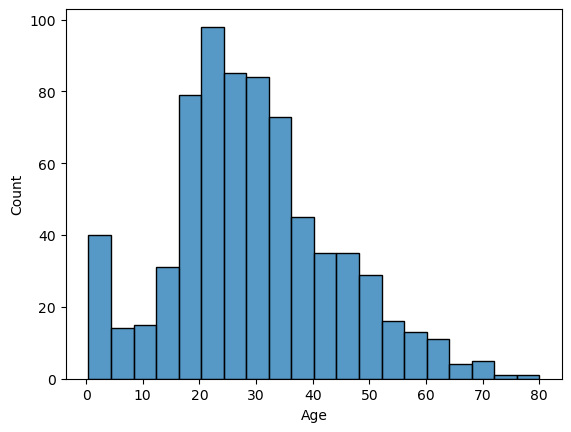

In [6]:
sns.histplot(data = dados, x='Age')

In [7]:
dados['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

<Axes: xlabel='Embarked', ylabel='Count'>

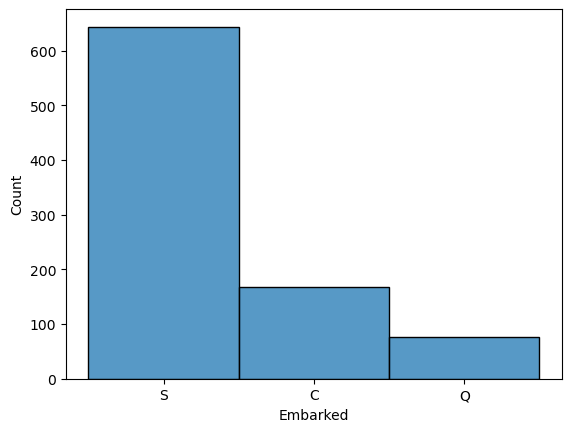

In [8]:
sns.histplot(data = dados, x='Embarked', bins = 50)

# Tratamento dos dados

### Tratamento dos dados de idade
- As idades serão convertidas para números inteiros e os valores faltantes serão substituidos pela idade mediana, devido a 
- Os pontos de embarque (Embarked) serão substituidos pelo ponto que mais aparece (moda)

<Axes: xlabel='Age', ylabel='Count'>

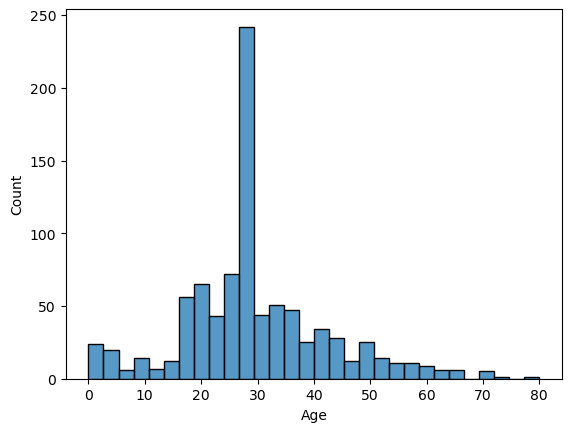

In [9]:
#Substituindo as idades faltantes pela média
mediana = round(dados['Age'].median(), 0)
dados['Age'].fillna(mediana, inplace = True)

#Convertendo a idade para números inteiros
dados['Age'] = dados['Age'].astype(int)

sns.histplot(data = dados, x='Age')

In [10]:
#Substituindo os pontos de embarque faltantes pela moda
dados['Embarked'].fillna('S', inplace=True)

In [11]:
dados.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

# Transformação de variáveis categóricas para numéricas

In [12]:
label = LabelEncoder()
dados_transf = pd.DataFrame()
dados_transf['Sex'] = label.fit_transform(dados['Sex'])
dados_transf['Embarked'] = label.fit_transform(dados['Embarked'])
#dados_transf['Cabin'] = label.fit_transform(dados['Cabin'])
dados_transf = pd.concat([dados_transf,
                          dados['Pclass'],
                          dados['Age'], 
                          dados['SibSp'],
                          dados['Parch'],
                          dados['Fare'],
                          dados['Survived']],
                         axis = 1)
dados_transf.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare,Survived
0,1,2,3,22,1,0,7.2500,0
1,0,0,1,38,1,0,71.2833,1
2,0,2,3,26,0,0,7.9250,1
3,0,2,1,35,1,0,53.1000,1
4,1,2,3,35,0,0,8.0500,0


# Preparação do modelo

In [13]:
previsor = dados_transf.iloc[:,0:7]
classe = dados_transf.iloc[:,7]

In [14]:
x_treino, x_teste, y_treino, y_teste = train_test_split(previsor, classe, 
                                                        test_size = 0.3,
                                                        random_state = 0)

# Treinando modelo sem balanceamento

#### Modelo SVC DESBALANCEADO

In [15]:
#Descobrindo a taxa de acerto do modelo SVC
svm_desb = svm.SVC(random_state=0)
svm_desb.fit(x_treino, y_treino)

svm_prev_desb = svm_desb.predict(x_teste)
taxa_acerto_svc_desb = recall_score(y_teste, svm_prev_desb)
print(f'Taxa de acerto: {taxa_acerto_svc_desb*100:.2f}')

Taxa de acerto: 32.00


In [16]:
svm_desbalanceado = confusion_matrix(y_teste, 
                                     svm_prev_desb)
print('Matriz de confusão\n', svm_desbalanceado)

Matriz de confusão
 [[160   8]
 [ 68  32]]


#### Modelo ExtraTreesClassifier DESBALANCEADO

In [17]:
#Descobrindo a média de acerto do modelo
media_ETC_desb = []

for i in range(11):
    et_desb = ExtraTreesClassifier(random_state = 1)
    et_desb.fit(x_treino, y_treino)
    prev_et_desb = et_desb.predict(x_teste)
    media_ETC_desb.append(recall_score(y_teste, prev_et_desb))
    
taxa_acerto_etc_media = np.mean(media_ETC_desb)
print(f'Taxa média de acerto: {taxa_acerto_etc_media*100:.2f}')

Taxa média de acerto: 72.00


In [18]:
et_desbalanceado = confusion_matrix(y_teste, 
                                    prev_et_desb)
print('Matriz de confusão\n', et_desbalanceado)

Matriz de confusão
 [[143  25]
 [ 28  72]]


#### Modelo RandomForestClassifier DESBALANCEADO

In [19]:
#Descobrindo a média de acerto do modelo
media_rfc_desb = []

for i in range(11):
    rfc_desb = RandomForestClassifier(random_state=i)
    rfc_desb.fit(x_treino, y_treino)
    prev_rfc_desb = rfc_desb.predict(x_teste)
    media_rfc_desb.append(recall_score(y_teste, prev_rfc_desb))

taxa_acerto_rfc_media = np.mean(media_rfc_desb)
print(f'Taxa média de acerto: {taxa_acerto_rfc_media*100:.2f}')

Taxa média de acerto: 74.00


In [20]:
rf_desbalanceado = confusion_matrix(y_teste,
                                    prev_rfc_desb)
print('Matriz de confusão\n', rf_desbalanceado)

Matriz de confusão
 [[145  23]
 [ 25  75]]


### Fazendo balanceamento OverSample 

In [21]:
os = RandomOverSampler(random_state = 0)
x_res, y_res = os.fit_resample(x_treino,
                               y_treino)

# Treinando modelo com balanceamento

#### Modelo SVC BALANCEADO

In [22]:
#Descobrindo a taxa de acerto do modelo
svm_balanc = svm.SVC(random_state = 0)
svm_balanc.fit(x_treino, y_treino)

prev_svm_balanc = svm_balanc.predict(x_teste)
taxa_acerto_svm_balanc = recall_score(y_teste, prev_svm_balanc)
print(f'Taxa de acerto: {taxa_acerto_svm_balanc*100:.2f}')

Taxa de acerto: 32.00


In [23]:
svm_balanceado = confusion_matrix(y_teste,
                                  prev_svm_balanc)
print('Matriz de confusão\n', svm_balanceado)

Matriz de confusão
 [[160   8]
 [ 68  32]]


#### Modelo ExtraTreesClassifier BALANCEADO

In [24]:
media_etc_balanc = []

for i in range(11):
    etc_balanc = ExtraTreesClassifier(random_state=i)
    etc_balanc.fit(x_treino, y_treino)
    prev_etc_balanc = etc_balanc.predict(x_teste)
    media_etc_balanc.append(recall_score(y_teste, prev_etc_balanc))
    
taxa_acerto_etc_balanc = np.mean(media_etc_balanc)

print(f'Taxa de acerto: {taxa_acerto_etc_balanc*100:.2f}')

Taxa de acerto: 71.00


In [25]:
et_balanceado = confusion_matrix(y_teste,
                                 prev_etc_balanc)
print('Matriz de confusão\n', et_balanceado)

Matriz de confusão
 [[146  22]
 [ 29  71]]


#### Modelo RandomForestClassifier BALANCEADO

In [26]:
media_rfc_balanc = []
for i in range(11):
    rfc_balanc = RandomForestClassifier(random_state=i)
    rfc_balanc.fit(x_treino, y_treino)
    prev_rfc_balanc = rfc_balanc.predict(x_teste)
    media_rfc_balanc.append(recall_score(y_teste, prev_rfc_balanc))
    
taxa_acerto_rfc_balanc = np.mean(media_rfc_balanc)

print(f'Taxa de acerto: {taxa_acerto_rfc_balanc*100:.2f}')

Taxa de acerto: 74.00


In [27]:
rf_balanceado = confusion_matrix(y_teste, prev_rfc_balanc)
print('Matriz de confusão\n', rf_balanceado) 

Matriz de confusão
 [[145  23]
 [ 25  75]]


### Escolha do modelo 

O modelo escolhido será o Random Forest Classifier, devido a taxa de acerto ser de 73%, independente do balanceamento

In [28]:
importancia = rfc_balanc.feature_importances_
importancia = np.round(importancia*100, decimals=2)

In [29]:
print(' Colunas:', previsor.columns.to_list(), '\n','Imporância:', importancia )

 Colunas: ['Sex', 'Embarked', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] 
 Imporância: [26.42  4.13  8.6  25.68  5.39  3.82 25.97]


# Carregando os dados de previsão

In [30]:
dados_prev = pd.read_csv('test.csv')
dados_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### tratamento de dados faltantes

<Axes: xlabel='Age', ylabel='Count'>

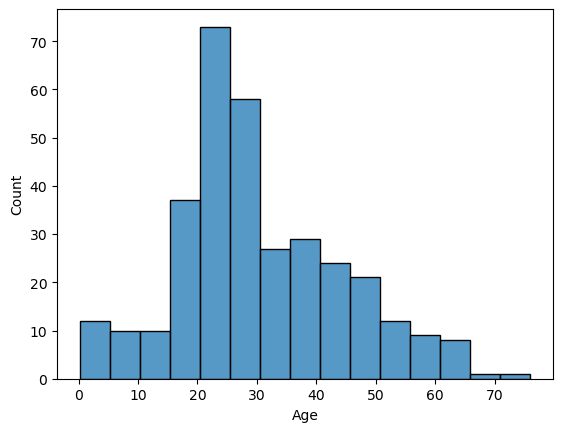

In [31]:
#Plotando a distribuição de idade
sns.histplot(data = dados_prev, x = 'Age')

In [32]:
#Substituindo valores faltantes pela média
media = round(np.mean(dados_prev['Age']),0)
dados_prev['Age'].fillna(media, inplace=True)

#Convertendo float para int
dados_prev['Age']=dados_prev['Age'].astype(int)

<Axes: xlabel='Fare', ylabel='Count'>

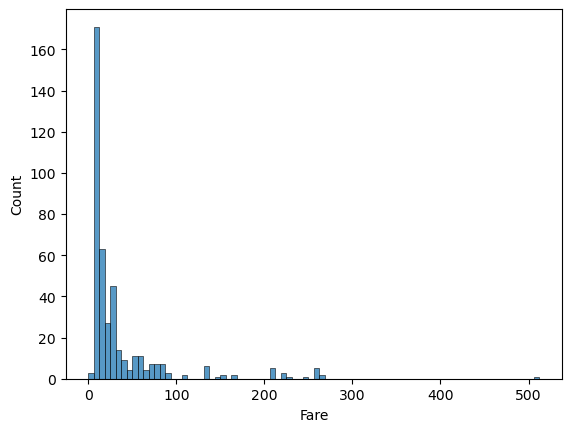

In [33]:
#Plotando a distibuição de Fare
sns.histplot(data = dados_prev, x = 'Fare')

In [34]:
#Substituindo valores faltantes pela média
media = np.mean(dados_prev['Fare'])
dados_prev['Fare'].fillna(media, inplace=True)

In [35]:
dados_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    int32  
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 34.4+ KB


In [36]:
#Criando um DataFrame com os valores convertidos para previsão
prev_transform = pd.DataFrame()
prev_transform['Sex'] = label.fit_transform(dados_prev['Sex'])
prev_transform['Embarked'] = label.fit_transform(dados_prev['Embarked'])

dados_prev_transform = pd.concat([prev_transform,
                                  dados_prev['Pclass'],
                                  dados_prev['Age'], 
                                  dados_prev['SibSp'],
                                  dados_prev['Parch'],
                                  dados_prev['Fare']],
                                 axis=1)

dados_prev_transform

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,1,1,3,34,0,0,7.8292
1,0,2,3,47,1,0,7.0000
2,1,1,2,62,0,0,9.6875
3,1,2,3,27,0,0,8.6625
4,0,2,3,22,1,1,12.2875
...,...,...,...,...,...,...,...
413,1,2,3,30,0,0,8.0500
414,0,0,1,39,0,0,108.9000
415,1,2,3,38,0,0,7.2500
416,1,2,3,30,0,0,8.0500


In [37]:
p_survived = {'Survived' : rfc_desb.predict(dados_prev_transform)}
len(rfc_desb.predict(dados_prev_transform))

418

In [47]:
previsao_submit = pd.DataFrame(p_survived)
previsao_submit = pd.concat([dados_prev['PassengerId'], previsao_submit], axis=1)
previsao_submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [65]:
previsao_submit.to_csv('Sub.csv', index=False)

In [66]:
pd.read_csv('Sub.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
